In [1]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import raster_plot



In [4]:
#Import the data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip.bil")#Get raster data

dem = raster.ReadAsArray()


creek= "Perkins_creek"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3010.tree" #Set file name
csv_name = "Cache_creek_clip_fullProfileMC_forced_0.5_20_-4924088_20_90_3010_for_Arc.csv"

## IMPORT DATA for csv or tree files
#for csv files
creek_data = np.genfromtxt((path+csv_name), delimiter=',', skip_header=1, names=['id', 'x', 'y', 'chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])
#for tree files
#creek_data = np.genfromtxt((path+name), delimiter=' ', skip_header=1, names=['chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])


In [65]:
def plot_coord(raster):

    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = raster.GetGeoTransform()
    dx = x_size
    dy = y_size
    nx, ny = raster.RasterXSize, raster.RasterYSize  # Size of the original raster

    xllcenter = upper_left_x + dx/2  # x coordinate center of lower left pxl
    yllcenter = upper_left_y - dx/2 # y coordinate center of lower left pxl   - (ny-1)*dx 

    #Create arrays of the x and y coordinates of each pixel (the axes)
    xcoordinates = [x*dx + xllcenter for x in range(nx)]
    ycoordinates = [y*dy + yllcenter for y in range(ny)]

    #Create 2 2d grids describing x and y coordinates
    X,Y = np.meshgrid(xcoordinates, ycoordinates) 


    #fig = plt.contourf(X, Y, dem, levels=np.linspace(np.amin(dem[dem > 0]),np.amax(dem), 50))

    return X, Y#, fig

X,Y = plot_coord(raster)

In [ ]:
(upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = raster.GetGeoTransform()
    dx = x_size
    dy = y_size
    nx, ny = raster.RasterXSize, raster.RasterYSize  # Size of the original raster


In [61]:
(upper_left_x, x_res, x_rotation, upper_left_y, y_rotation, y_res) = raster.GetGeoTransform()
nx_creek = max(creek_data['x']) - min(creek_data['x'])
ny_creek = max(creek_data['y']) - min(creek_data['y'])

print(min(creek_data['x'])/x_res)
print(x_res)
print(max(creek_data['y'])/x_res)
print(y_res)



#DONE!!
xoff = ((min(creek_data['x'])-upper_left_x)/x_res).astype(int).item()
yoff = ((upper_left_y - max(creek_data['y']))/x_res).astype(int).item()
xsize = (nx_creek/x_res).astype(int).item()
ysize = (ny_creek/x_res).astype(int).item()

print('')
print(xoff)
print(yoff)

58560.8074995
9.14947916667
471651.429266
-9.14967195189

2805
3482


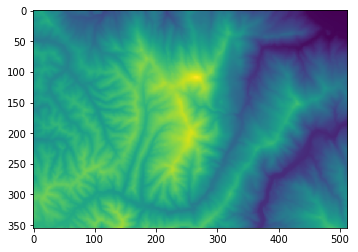

In [63]:
array_part = raster.ReadAsArray(
    xoff=xoff,
    yoff=yoff,
    xsize=xsize,
    ysize=ysize)

plt.imshow(array_part)
plt.show()



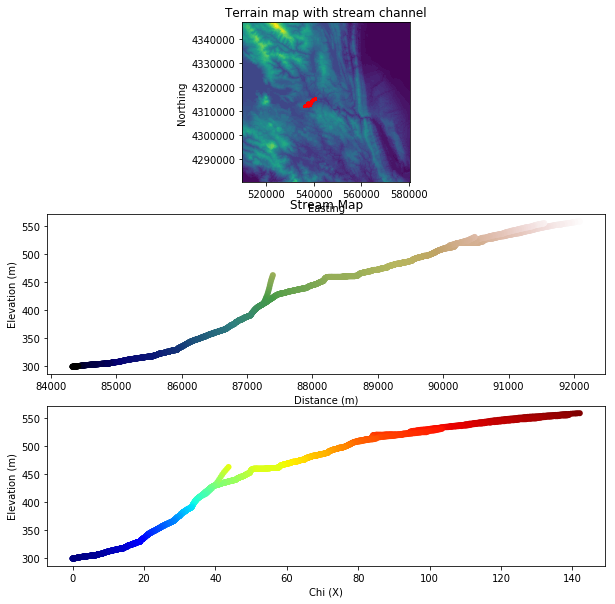

In [66]:


cm = plt.cm.gist_earth


fig, ax = plt.subplots(3, figsize=(10,10), sharex=False) #define 2 subfigures

ax[0].contourf(X, Y, dem, levels=np.linspace(np.amin(dem[dem > 0]),np.amax(dem), 50))
#ax[0].imshow(dem, interpolation='nearest', vmin=0, cmap=cm) 
ax[0].plot(creek_data['x'], creek_data['y'], 'ro',  markersize=2, markeredgewidth=0.0)
ax[0].set_aspect('equal')
ax[0].set_title('Terrain map with stream channel')
ax[0].set_ylabel('Northing')
ax[0].set_xlabel('Easting')


ax[1].scatter(creek_data['flow_distance'], creek_data['elevation'], c=creek_data['elevation'], cmap=cm, edgecolors='none')
ax[1].set_title('Stream Map')
ax[1].set_ylabel('Elevation (m)')
ax[1].set_xlabel('Distance (m)')


ax[2].scatter(creek_data['chi'], creek_data['elevation'], c=creek_data['elevation'], cmap=plt.get_cmap("jet"), edgecolors='none')
#ax[2].text(3, 2500, 'm/n = 0.45')
ax[2].set_ylabel('Elevation (m)')
ax[2].set_xlabel('Chi (X)')


plt.show()